In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima

In [2]:
df = pd.read_csv("../data/processed/sales_daily_features.csv", parse_dates=["date"])

In [3]:
df

,date,total,weekday_num,temperature_2m_max,temperature_2m_min,precipitation_sum,windspeed_10m_max,is_holiday,is_holiday_eve,is_holiday_after
0,2023-01-01,"615,17",7,14.5,3.6,0.0,12.3,False,False,False
1,2023-01-02,"502,52",1,11.3,6.7,1.1,10.2,False,False,False
2,2023-01-04,"546,31",3,11.0,0.5,0.0,7.5,False,False,False
3,2023-01-05,"511,99",4,10.8,0.7,0.0,9.5,False,True,False
4,2023-01-06,"644,96",5,9.7,-1.1,0.0,8.0,True,False,False
...,...,...,...,...,...,...,...,...,...,...
902,2025-12-12,"454,03",5,11.9,4.4,0.0,10.9,False,False,False
903,2025-12-13,"1.440,83",6,14.0,5.4,0.0,10.0,False,False,False
904,2025-12-14,"642,32",7,11.2,3.7,0.0,9.4,False,False,False
905,2025-12-17,"485,50",3,13.2,7.5,0.0,15.5,False,False,False


In [4]:
df = df.sort_values("date").copy()

df["total"] = (df["total"].astype(str)
               .str.replace(".", "", regex=False)   # quita miles tipo 1.440,83
               .str.replace(",", ".", regex=False)) # coma decimal -> punto
df["total"] = pd.to_numeric(df["total"], errors="coerce")

df["total"].dtype, df["total"].isna().sum(), df["total"].describe()

(dtype('float64'),
 np.int64(0),
 count     907.000000
 mean      512.022051
 std       261.468567
 min         0.000000
 25%       313.950000
 50%       476.090000
 75%       685.885000
 max      1475.890000
 Name: total, dtype: float64)

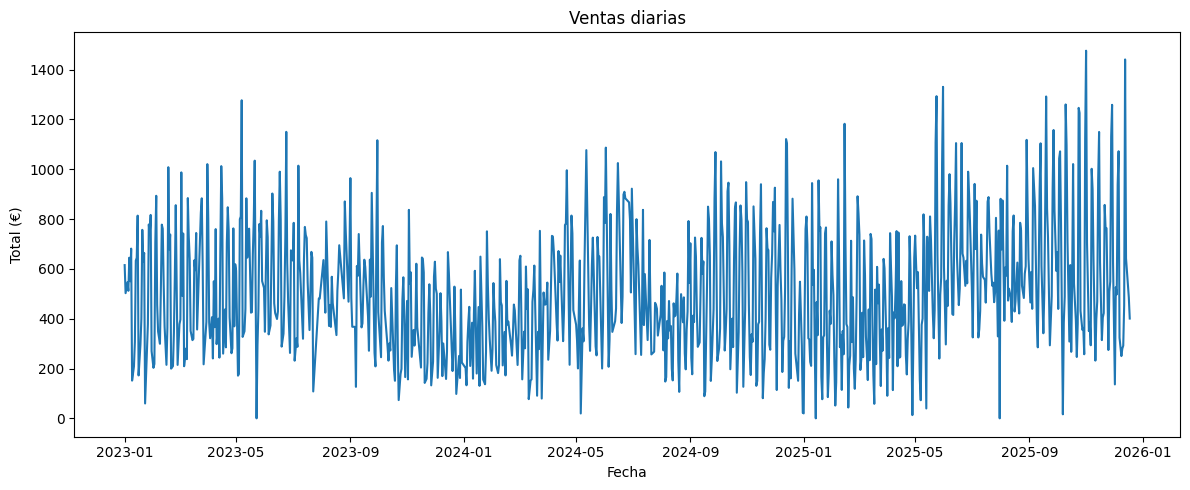

In [5]:
df = df.sort_values("date")

plt.figure(figsize=(12,5))
sns.lineplot(data=df, x="date", y="total")
plt.title("Ventas diarias")
plt.xlabel("Fecha")
plt.ylabel("Total (€)")
plt.tight_layout()
plt.show()

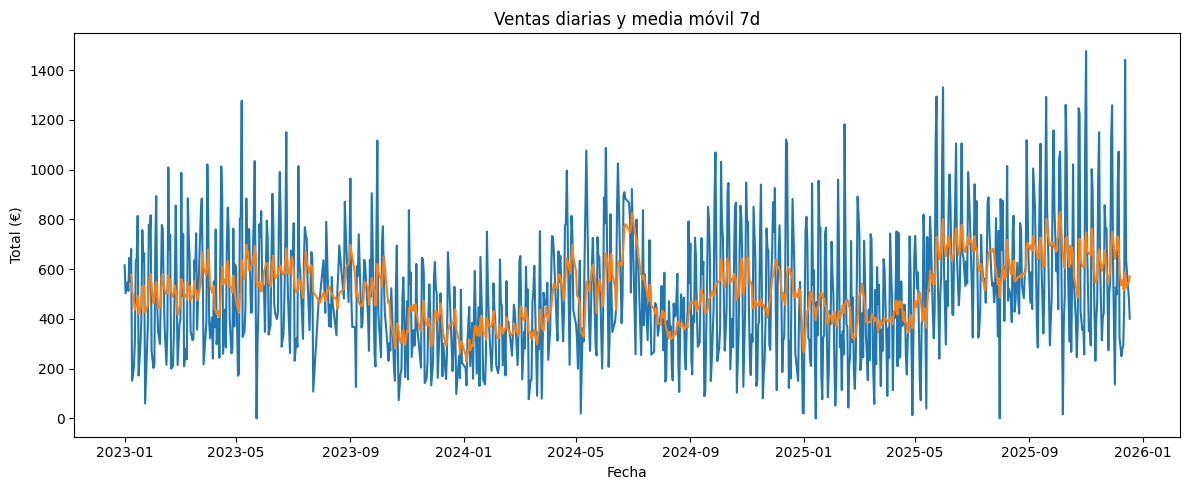

In [6]:
df["total_7d"] = df["total"].rolling(7).mean()

plt.figure(figsize=(12,5))
plt.plot(df["date"], df["total"])
plt.plot(df["date"], df["total_7d"])
plt.title("Ventas diarias y media móvil 7d")
plt.xlabel("Fecha")
plt.ylabel("Total (€)")
plt.tight_layout()
plt.show()

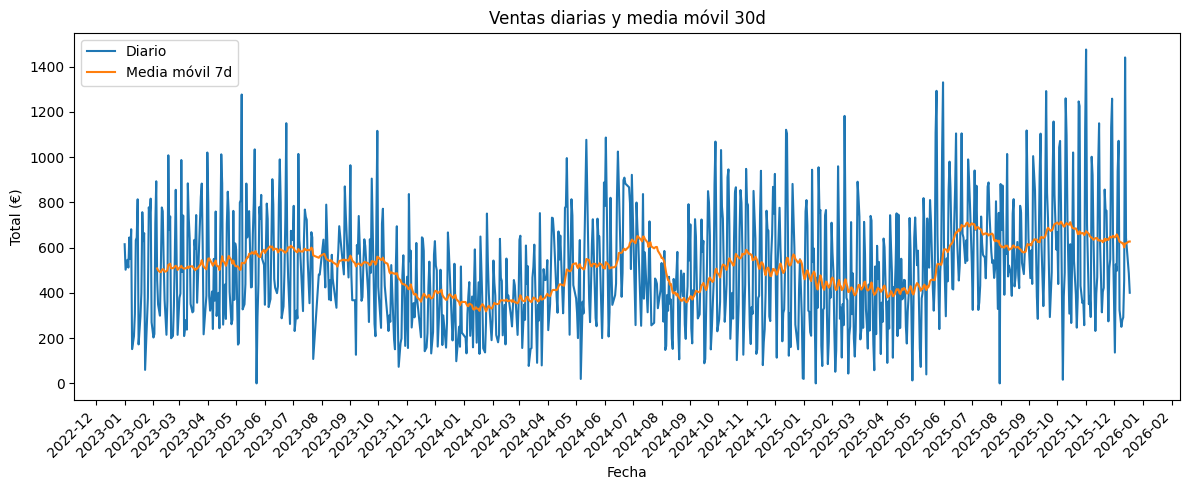

In [7]:
import matplotlib.dates as mdates
df = df.sort_values("date").copy()
df["total_30d"] = df["total"].rolling(30).mean()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df["date"], df["total"], label="Diario")
ax.plot(df["date"], df["total_30d"], label="Media móvil 7d")

ax.set_title("Ventas diarias y media móvil 30d")
ax.set_xlabel("Fecha")
ax.set_ylabel("Total (€)")

# ✅ ticks mensuales
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))     # cada mes
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))     # 2023-01, 2023-02, ...

plt.xticks(rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()

In [8]:
all_days = pd.date_range(df["date"].min(), df["date"].max(), freq="D")
missing = all_days.difference(df["date"])
len(missing), missing[:10]

(176,
 DatetimeIndex(['2023-01-03', '2023-01-10', '2023-01-17', '2023-01-24',
                '2023-01-25', '2023-01-31', '2023-02-07', '2023-02-14',
                '2023-02-21', '2023-02-28'],
               dtype='datetime64[ns]', freq=None))

In [9]:
ts = (df.set_index("date")["total"]
        .asfreq("D")
        .fillna(0))

In [10]:
all_days = pd.date_range(df["date"].min(), df["date"].max(), freq="D")
missing = all_days.difference(df["date"])
len(missing), missing[:10]

(176,
 DatetimeIndex(['2023-01-03', '2023-01-10', '2023-01-17', '2023-01-24',
                '2023-01-25', '2023-01-31', '2023-02-07', '2023-02-14',
                '2023-02-21', '2023-02-28'],
               dtype='datetime64[ns]', freq=None))

In [11]:
decomposition = seasonal_decompose(df["total"], period = 30)
decomposition

In [12]:
ts = df.set_index("date")["total"].astype(float).to_numpy()   
tensor = ts.reshape(-1, 1)                                   
tensor.shape

(907, 1)

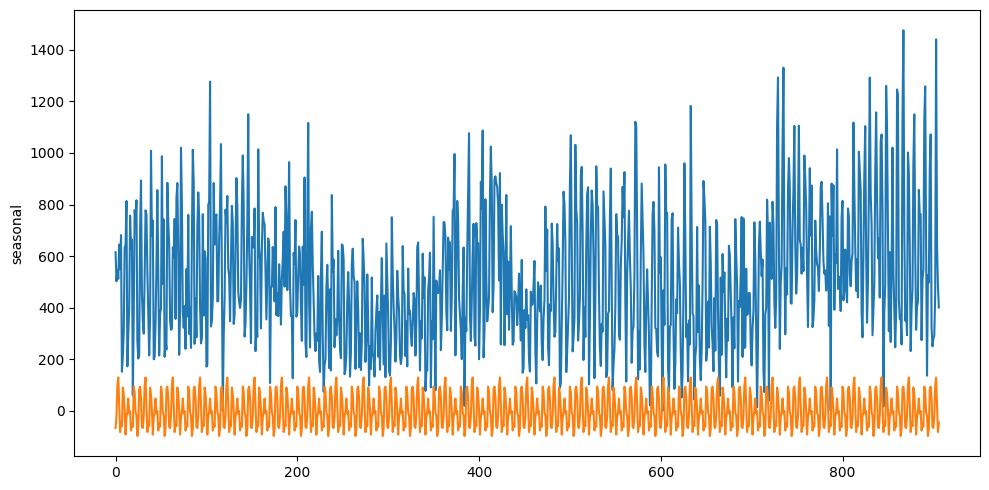

In [13]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

In [14]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                  -2.775386
p-value                          0.061877
#Lags Used                      20.000000
Number of Observations Used    886.000000
Critical Value (1%)             -3.437752
Critical Value (5%)             -2.864808
Critical Value (10%)            -2.568510
dtype: float64

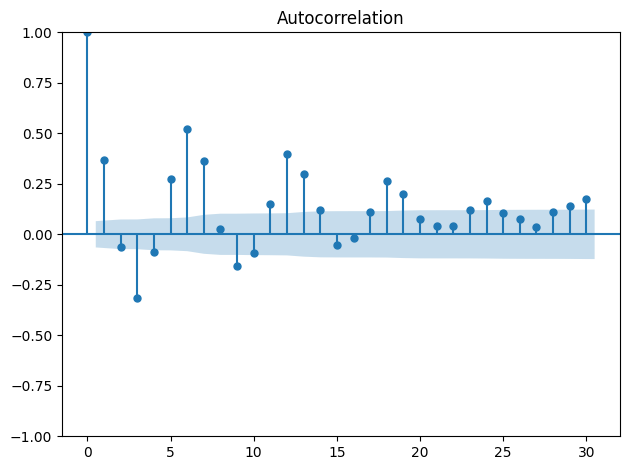

In [15]:
plot_acf(ts)

plt.tight_layout()

plt.show()

In [16]:
ts = df.set_index("date")["total"].astype(float)
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -1.033049e+01
p-value                        2.851023e-18
#Lags Used                     1.900000e+01
Number of Observations Used    8.860000e+02
Critical Value (1%)           -3.437752e+00
Critical Value (5%)           -2.864808e+00
Critical Value (10%)          -2.568510e+00
dtype: float64

In [17]:
model = auto_arima(ts_stationary, seasonal=True, m=7, trace=True)
model_sin_diff = auto_arima(ts, seasonal=True, m=7, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=12319.971, Time=3.13 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=12870.265, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=12818.516, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=12514.119, Time=1.01 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=12868.266, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=12450.159, Time=3.11 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=12453.792, Time=2.11 sec
 ARIMA(2,0,2)(2,0,1)[7] intercept   : AIC=12454.396, Time=3.20 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=12319.891, Time=4.38 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=12451.786, Time=3.87 sec
 ARIMA(2,0,2)(2,0,2)[7] intercept   : AIC=12452.504, Time=3.96 sec
 ARIMA(1,0,2)(1,0,2)[7] intercept   : AIC=12448.429, Time=2.47 sec
 ARIMA(2,0,1)(1,0,2)[7] intercept   : AIC=12402.952, Time=3.26 sec
 ARIMA(3,0,2)(1,0,2)[7] intercept   : AIC=12233.508, Time=4.02 sec
 ARIMA(3,0,2)(0,0,2

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  906
Model:             SARIMAX(5, 0, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -6098.303
Date:                                Fri, 19 Dec 2025   AIC                          12216.606
Time:                                        16:17:27   BIC                          12264.696
Sample:                                             0   HQIC                         12234.971
                                                - 906                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1479      0.054     -2.731      0.006      -0.254      -0.042
ar.L2         -0.3917      0.039    -10.144      0.000      -0.467      -0.316
ar.L3         -0.5446      0.034    -15.938      0.000      -0.612      -0.478
ar.L4         -0.3553      0.042     -8.439      0.000      -0.438      -0.273
ar.L5         -0.1913      0.045     -4.298      0.000      -0.279      -0.104
ma.L1         -0.6082      0.047    -12.876      0.000      -0.701      -0.516
ar.S.L7        0.7660      0.132      5.804      0.000       0.507       1.025
ma.S.L7       -0.8635      0.135     -6.374      0.000      -1.129      -0.598
ma.S.L14       0.1450      0.033      4.349      0.000       0.080       0.210
sigma2      4.105e+04   1851.039     22.176      0.000    3.74e+04    4.47e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 6.51
Prob(Q):                              0.94   Prob(JB):                         0.04
Heteroskedasticity (H):               1.15   Skew:                             0.18
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
model_sin_diff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  907
Model:             SARIMAX(5, 1, 5)x(1, 0, [1, 2], 7)   Log Likelihood               -6079.043
Date:                                Fri, 19 Dec 2025   AIC                          12186.085
Time:                                        16:17:27   BIC                          12253.412
Sample:                                             0   HQIC                         12211.796
                                                - 907                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3956      0.081     -4.877      0.000      -0.555      -0.237
ar.L2         -0.6900      0.059    -11.727      0.000      -0.805      -0.575
ar.L3         -0.3618      0.059     -6.141      0.000      -0.477      -0.246
ar.L4         -0.8299      0.048    -17.429      0.000      -0.923      -0.737
ar.L5         -0.1831      0.066     -2.774      0.006      -0.312      -0.054
ma.L1         -0.3606      0.076     -4.734      0.000      -0.510      -0.211
ma.L2          0.1232      0.067      1.852      0.064      -0.007       0.254
ma.L3         -0.4972      0.062     -7.991      0.000      -0.619      -0.375
ma.L4          0.4835      0.065      7.466      0.000       0.357       0.610
ma.L5         -0.4419      0.062     -7.077      0.000      -0.564      -0.319
ar.S.L7        0.7102      0.130      5.454      0.000       0.455       0.965
ma.S.L7       -0.7753      0.136     -5.717      0.000      -1.041      -0.509
ma.S.L14       0.1509      0.039      3.827      0.000       0.074       0.228
sigma2      4.101e+04   1950.980     21.020      0.000    3.72e+04    4.48e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.97
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               1.12   Skew:                             0.22
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
day_to_predict = 3
forecast = model.predict(day_to_predict)
forecast_sin_diff = model_sin_diff.predict(day_to_predict)
forecast

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will r

906     -5.944942
907    233.536261
908    237.935382
dtype: float64

In [24]:
forecast_sin_diff

907    461.207041
908    662.575211
909    946.059846
dtype: float64

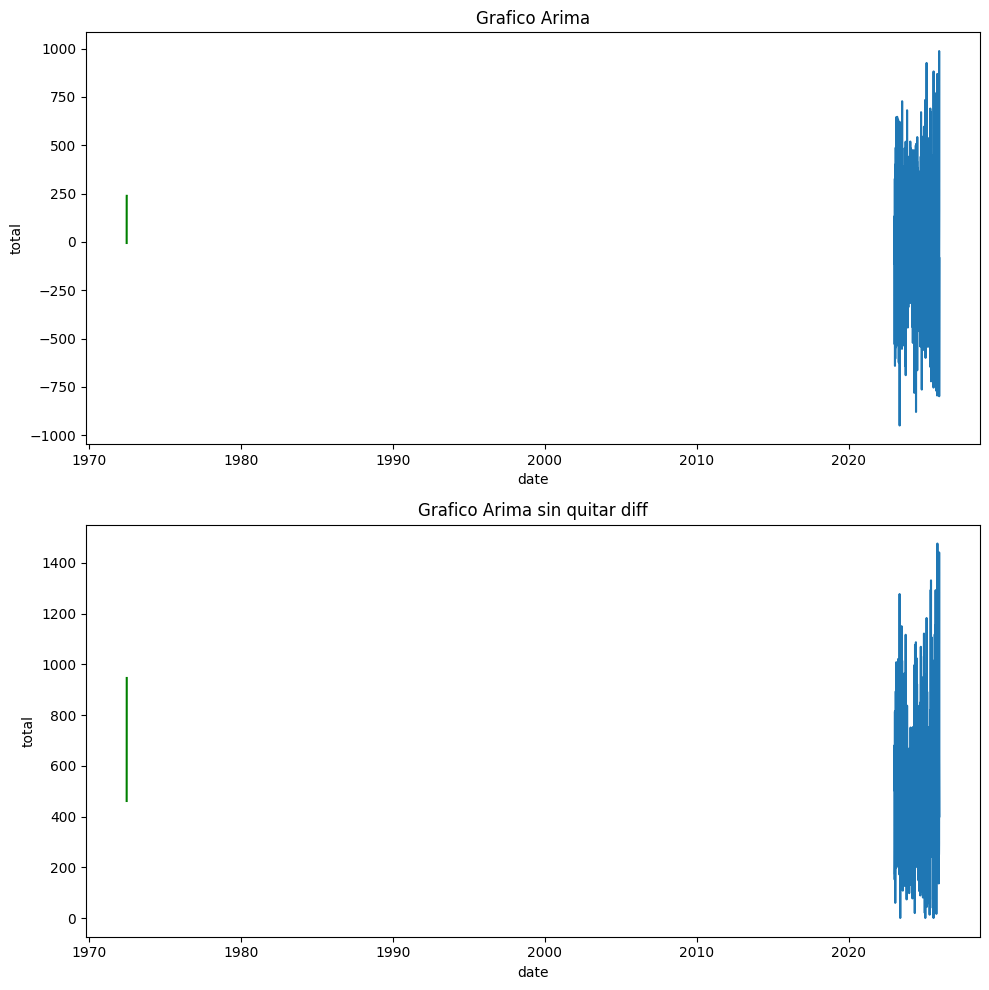

In [25]:
fig, axis = plt.subplots(2, 1, figsize=(10, 10))

sns.lineplot(ax=axis[0], data=ts_stationary).set(title="Grafico Arima")
sns.lineplot(ax=axis[0], data=forecast, c="green")
sns.lineplot(ax=axis[1], data=ts).set(title="Grafico Arima sin quitar diff")
sns.lineplot(ax=axis[1], data=forecast_sin_diff, c="green")

plt.tight_layout()

plt.show()